# Lab 4

**Adam Aiken**

March 5th, 2025

## Part 2 - Set-Up

Make sure that you're using Github secrets for your API keys. I shouldn't see them in your code.

And, you'll need to do some `pip install` to get the necessary packages.

In [ ]:
# Set-up, data import, and check

#!pip install fredapi

import numpy as np
import pandas as pd
import datetime as dt

from datetime import timedelta

import seaborn as sns



# plotting packages
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as clrs


from fredapi import Fred
import os

# My Secret for this Repo is called FRED. I can also bring in my NASDAQ secret if I want.
FRED_API_KEY = os.environ.get('FRED')
NASDAQ_API_KEY = os.environ.get('NASDAQ')


# Here, I'm setting the API key so that I can access the FRED server
fred = Fred(api_key=FRED_API_KEY)



In [2]:
data = fred.get_series('SP500')
data

2015-03-09    2079.43
2015-03-10    2044.16
2015-03-11    2040.24
2015-03-12    2065.95
2015-03-13    2053.40
               ...   
2025-03-03    5849.72
2025-03-04    5778.15
2025-03-05    5842.63
2025-03-06    5738.52
2025-03-07    5770.20
Length: 2610, dtype: float64

## Part 3 - Get Our Data

In [3]:
#Set-up GDP

gdp = fred.get_series('GDP')
gdp.info()

<class 'pandas.core.series.Series'>
DatetimeIndex: 316 entries, 1946-01-01 to 2024-10-01
Series name: None
Non-Null Count  Dtype  
--------------  -----  
312 non-null    float64
dtypes: float64(1)
memory usage: 4.9 KB


In [4]:
gdp

1946-01-01          NaN
1946-04-01          NaN
1946-07-01          NaN
1946-10-01          NaN
1947-01-01      243.164
                ...    
2023-10-01    28296.967
2024-01-01    28624.069
2024-04-01    29016.714
2024-07-01    29374.914
2024-10-01    29719.647
Length: 316, dtype: float64

In [5]:
gdp = gdp.to_frame(name='gdp')
gdp = gdp.rename_axis("date")

gdp.index = gdp.index - timedelta(days=1)

gdp = gdp.resample('ME').ffill()
gdp

,gdp
date,
1945-12-31,NaN
1946-01-31,NaN
1946-02-28,NaN
1946-03-31,NaN
1946-04-30,NaN
...,...
2024-05-31,29016.714
2024-06-30,29374.914
2024-07-31,29374.914


I got a warning about using 'M', so I switched it to 'ME', as suggested. 'ME' is month-end, which makes more sense.

In [6]:
# Set-up unrate

unrate = fred.get_series('UNRATE')
unrate.info()

<class 'pandas.core.series.Series'>
DatetimeIndex: 925 entries, 1948-01-01 to 2025-01-01
Series name: None
Non-Null Count  Dtype  
--------------  -----  
925 non-null    float64
dtypes: float64(1)
memory usage: 14.5 KB


In [7]:
unrate = unrate.to_frame(name='unrate')
unrate = unrate.rename_axis("date")
unrate

,unrate
date,
1948-01-01,3.4
1948-02-01,3.8
1948-03-01,4.0
1948-04-01,3.9
1948-05-01,3.5
...,...
2024-09-01,4.1
2024-10-01,4.1
2024-11-01,4.2


In [8]:
unrate.index = unrate.index - timedelta(days=1)
unrate = unrate.resample('ME').ffill()
unrate

,unrate
date,
1947-12-31,3.4
1948-01-31,3.8
1948-02-29,4.0
1948-03-31,3.9
1948-04-30,3.5
...,...
2024-08-31,4.1
2024-09-30,4.1
2024-10-31,4.2


## Part 4 - Joining Our Data Together

In [9]:
df_inner = pd.merge(gdp, unrate, how='inner', on='date')
df_inner

,gdp,unrate
date,,
1947-12-31,265.742,3.4
1948-01-31,265.742,3.8
1948-02-29,265.742,4.0
1948-03-31,272.567,3.9
1948-04-30,272.567,3.5
...,...,...
2024-05-31,29016.714,4.1
2024-06-30,29374.914,4.2
2024-07-31,29374.914,4.2


In [10]:
df_outer = pd.merge(gdp, unrate, how='outer', on='date')
df_outer

,gdp,unrate
date,,
1945-12-31,NaN,NaN
1946-01-31,NaN,NaN
1946-02-28,NaN,NaN
1946-03-31,NaN,NaN
1946-04-30,NaN,NaN
...,...,...
2024-08-31,29374.914,4.1
2024-09-30,29719.647,4.1
2024-10-31,NaN,4.2


Do you see the difference between these two methods?

## Part 5 - Plot Using Pandas

In [11]:
df_inner['gdp_pct_change'] = df_inner['gdp'].pct_change()
df_inner['unrate_pct_change'] = df_inner['unrate'].pct_change()

df_inner_q = df_inner.asfreq('QE')

df_inner_q.head()


,gdp,unrate,gdp_pct_change,unrate_pct_change
date,,,,
1947-12-31,265.742,3.4,NaN,NaN
1948-03-31,272.567,3.9,0.025683,-0.025000
1948-06-30,279.196,3.6,0.024321,0.000000
1948-09-30,280.366,3.7,0.004191,-0.026316
1948-12-31,275.034,4.3,-0.019018,0.075000


Same here. I switched to 'QE', as suggested.

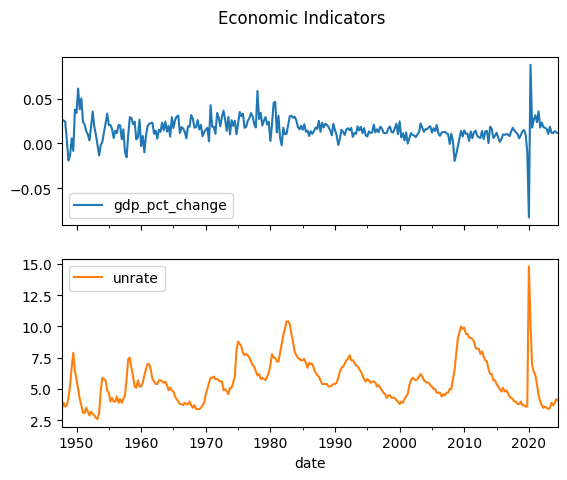

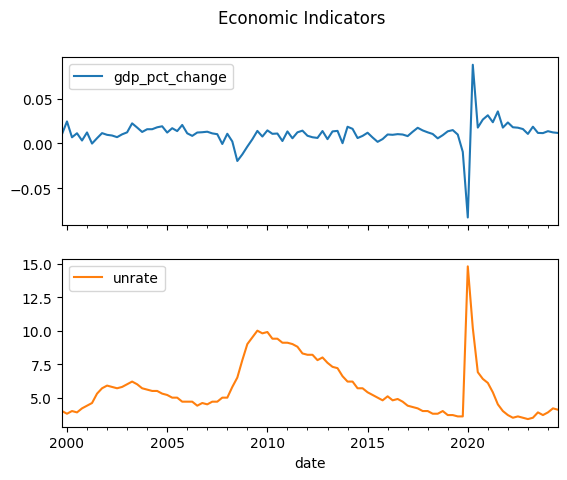

In [12]:
df_inner_q[['gdp_pct_change', 'unrate']].plot(subplots = True, title = 'Economic Indicators');

# Select just since December 1999

df_inner_q.loc['1999-12-31':,['gdp_pct_change', 'unrate']].plot(subplots = True, title = 'Economic Indicators');

## Part 6 - Correlation

In [13]:
df_inner_q.corr()

,gdp,unrate,gdp_pct_change,unrate_pct_change
gdp,1.000000,-0.003774,-0.190805,0.057436
unrate,-0.003774,1.000000,-0.059531,0.294089
gdp_pct_change,-0.190805,-0.059531,1.000000,-0.537367
unrate_pct_change,0.057436,0.294089,-0.537367,1.000000


<Axes: >

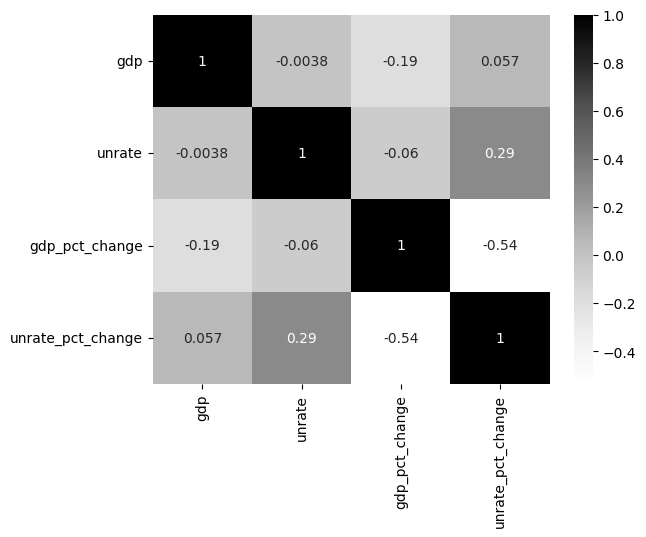

In [14]:
sns.heatmap(df_inner_q.corr(), annot = True, cmap = 'Greys')

## Part 7 - Wide to Long

In [15]:
df_inner_q.reset_index(inplace=True)

What does that step do? Why do we need it? What's an **index**? What does **inplace** mean?

In [16]:
df_inner_q_long = df_inner_q.melt(id_vars = 'date')
df_inner_q_long

,date,variable,value
0,1947-12-31,gdp,265.742000
1,1948-03-31,gdp,272.567000
2,1948-06-30,gdp,279.196000
3,1948-09-30,gdp,280.366000
4,1948-12-31,gdp,275.034000
...,...,...,...
1227,2023-09-30,unrate_pct_change,0.026316
1228,2023-12-31,unrate_pct_change,-0.026316
1229,2024-03-31,unrate_pct_change,0.000000
1230,2024-06-30,unrate_pct_change,0.024390


Let's change that just a bit. Do you see the difference?

In [17]:
df_inner_q_long = df_inner_q.melt(id_vars = 'date', var_name='indicator')
df_inner_q_long

,date,indicator,value
0,1947-12-31,gdp,265.742000
1,1948-03-31,gdp,272.567000
2,1948-06-30,gdp,279.196000
3,1948-09-30,gdp,280.366000
4,1948-12-31,gdp,275.034000
...,...,...,...
1227,2023-09-30,unrate_pct_change,0.026316
1228,2023-12-31,unrate_pct_change,-0.026316
1229,2024-03-31,unrate_pct_change,0.000000
1230,2024-06-30,unrate_pct_change,0.024390


In [18]:
df_inner_q_long_levels = df_inner_q.melt(id_vars = 'date', var_name='indicator', value_vars=['gdp', 'unrate'])
df_inner_q_long_levels

,date,indicator,value
0,1947-12-31,gdp,265.742
1,1948-03-31,gdp,272.567
2,1948-06-30,gdp,279.196
3,1948-09-30,gdp,280.366
4,1948-12-31,gdp,275.034
...,...,...,...
611,2023-09-30,unrate,3.900
612,2023-12-31,unrate,3.700
613,2024-03-31,unrate,3.900
614,2024-06-30,unrate,4.200
